# Lab 2

Вам потрібно згенерувати обраний дескриптор для обраного предмета, після чого з його допомогою розпізнати об’єкт на всій тестовій вибірці збираючи при цьому такі метрики: відносна кількість правильно суміщених ознак, похибка локалізації (відстань між реальним розміщенням предмета в кадрі та розпізнаним) та відносний час обробки фото в залежності від розміру зображення. Метрики мають зберегтись у файлику для подальших досліджень. 

Наступним кроком ви обмінюєтесь об’єктом з колегою, і уже маючи готову збиралку метрик, обчислюєте їх для предмета вашого сусіда.

Самою ж ідеєю лаби є дослідити розбіжності у роботі ваших дескрипторів та виконати порівняльний аналіз їх поведінки, сформулювати висновки з викладками і прикладами так аби було зрозуміло вам та, сподіваюсь, усім вашим колегам. Таким чином кінцевим результатом буде від вас **гуглдок з описом виняткових особливостей, сильних та слабких сторін дескриптора і обгрунтуванням чому вони поводяться саме так.**

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import time

from IPython.display import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [34]:
def open_photos(path='photos_anticeptik',orig = 'train_anticeptik.jpg', scale = 0.25):
    images = []
    names = os.listdir(path)
    names = list(filter(lambda x: str(x[-4:]) == ".jpg", names))
    names.sort(key = lambda x: int(x[:-4]))
    for filename in names:
        img = cv2.imread(os.path.join(path,filename), 0)
        if img is not None:
            img = cv2.resize(img, (0,0), fx=scale, fy=scale) 
            images.append(img) 
    
    image = cv2.imread(orig, 0)
    image = cv2.resize(image, (0,0), fx=scale, fy=scale)
    return images, names, image
    
test, names, train = open_photos(scale =0.25)

In [38]:
def feature_matching_pair(train, test, save_img = False):
    start = time.time()
    method = cv2.BRISK_create()
    kp1, des1 = method.detectAndCompute(train, None)
    kp2, des2 = method.detectAndCompute(test, None)
  
    MIN_MATCH_COUNT = 10
    
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck = True)
    matches = bf.match(des1,des2)

    good = matches
            
    if len(good)>=MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,90)
        matchesMask = mask.ravel().tolist()

        h,w = train.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        #test = cv2.polylines(test,[np.int32(dst)],True,255,10, cv2.LINE_AA)

    else:
        print("Not enough matches are found - {}/{}".format(len(good),MIN_MATCH_COUNT))
        return -1, -1, time.time() - start 
    
    t = time.time() - start
    
    if save_img:
        draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = (255, 0, 0),
                   matchesMask = matchesMask, 
                   flags = 0)
        result = cv2.drawMatches(train,kp1,test,kp2,good,None,**draw_params)
        cv2.imwrite('peow.jpg', result)
        
    m2 = 0
    for m in good:
        m2 += m.distance
    return sum(matchesMask,) / len(matchesMask), m2 / len(good), t
    


In [539]:
scale = 0.15
photo =  cv2.imread('photos_anticeptik/39.jpg', 0)
photo = cv2.resize(photo, (0,0), fx=scale, fy=scale)

(0.26158940397350994, 123.17549668874172, 0.4717433452606201)


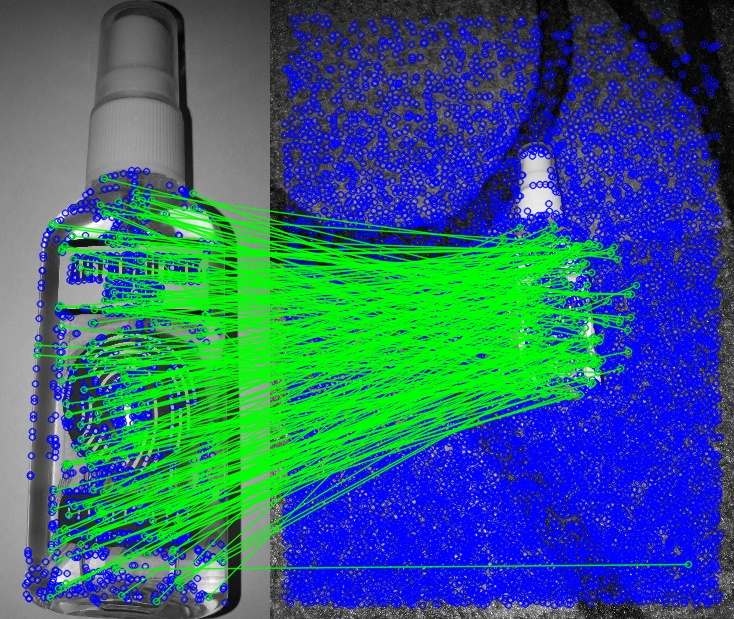

In [540]:
print(feature_matching_pair(train, photo, True))
Image('peow.jpg', width = 400, height = 300)

In [486]:
def get_data(scale = 0.25, scales = [], path="photos_cup", orig='train_cup.jpg'):
    data = pd.DataFrame({"id":[], "m1":[], "m2":[],"size":[], "x" + str(scale):[]})
    test, names, train = open_photos(path = path, scale = scale, orig=orig)
    for name, photo in zip(names, test):
        m1, m2, t = feature_matching_pair(train, photo)
        data = data.append({"id":name[:-4], "m1":m1, "m2":m2,"size":photo.shape, "x" + str(scale):t}, ignore_index=True)
    for scale_ in scales:
        temp_l = []
        test, names, train = open_photos(scale=scale_, path=path, orig=orig)
        for photo in test:
            m1, m2, t = feature_matching_pair(train, photo)
            temp_l.append(t)
        temp = pd.Series(temp_l, name= "x" + str(scale_))
        data["x" + str(scale_)] = temp
    return data

In [487]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales)

Not enough matches are found - 8/10


In [488]:
data.to_csv("cup_brisk.csv")

In [489]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales, path = 'photos_anticeptik', orig = 'train_anticeptik.jpg')

Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 9/10


In [490]:
data.to_csv("anticeptik_brisk.csv")

In [491]:
data_sift = pd.read_csv('cup_sift.csv')

In [492]:
sift_cup_time = sum(data_sift['x0.25']) + sum(data_sift['x0.2']) + sum(data_sift['x0.15']) 

In [493]:
data_asift = pd.read_csv('cup_asift.csv')

In [494]:
asift_cup_time = sum(data_asift['x0.25']) + sum(data_asift['x0.2']) + sum(data_asift['x0.15']) 

In [495]:
print("Cup: ASIFT / SIFT:",asift_cup_time / sift_cup_time)

Cup: ASIFT / SIFT: 35.43632457992017


In [496]:
data_sift_anticeptik = pd.read_csv('anticeptik_sift.csv')

In [497]:
sift_anticeptik_time = sum(data_sift_anticeptik['x0.25']) + sum(data_sift_anticeptik['x0.2']) + sum(data_sift_anticeptik['x0.15']) 

In [498]:
data_asift_anticeptik = pd.read_csv('anticeptik_asift.csv')

In [499]:
asift_anticeptik_time = sum(data_asift_anticeptik['x0.25']) + sum(data_asift_anticeptik['x0.2']) + sum(data_asift_anticeptik['x0.15']) 

In [500]:
print("Anticeptik: ASIFT / SIFT:",asift_anticeptik_time / sift_anticeptik_time)

Anticeptik: ASIFT / SIFT: 58.186712916791876


In [3]:
data_brisk_cup = pd.read_csv('cup_brisk.csv')

In [502]:
brisk_cup_time = sum(data_brisk_cup['x0.25']) + sum(data_brisk_cup['x0.2']) + sum(data_brisk_cup['x0.15']) 

In [503]:
print("Total BRISK cup-dataset time:", brisk_cup_time)

Total BRISK cup-dataset time: 54.52786421775818


In [504]:
print("Total SIFT cup-dataset time:", sift_cup_time)

Total SIFT cup-dataset time: 38.929930686950684


In [505]:
data_brisk_anticeptik = pd.read_csv('anticeptik_brisk.csv')

In [506]:
brisk_anticeptik_time = sum(data_brisk_anticeptik['x0.25']) + sum(data_brisk_anticeptik['x0.2']) + sum(data_brisk_anticeptik['x0.15']) 

In [507]:
print("Total BRISK anticeptik-dataset time:", brisk_anticeptik_time)

Total BRISK anticeptik-dataset time: 102.46825933456421


In [508]:
print("Total SIFT anticeptik-dataset time:", sift_anticeptik_time)

Total SIFT anticeptik-dataset time: 55.17288255691528


In [515]:
data_brisk_anticeptik.drop(columns="Unnamed: 0", inplace = True)
data_brisk_anticeptik.describe()

,id,m1,m2,x0.25,x0.2,x0.15
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,61.000000,0.295002,112.290567,0.336483,0.298552,0.211811
std,35.073732,0.241841,16.150035,0.302205,0.223137,0.097074
min,1.000000,-1.000000,-1.000000,0.158929,0.154804,0.142873
25%,31.000000,0.176534,109.778146,0.185917,0.178164,0.159926
50%,61.000000,0.289700,114.952849,0.217804,0.211111,0.171458
75%,91.000000,0.408759,117.927140,0.321827,0.287933,0.213307
max,121.000000,0.800000,133.609272,1.563258,1.207026,0.591340


In [4]:
data_brisk_cup.drop(columns="Unnamed: 0", inplace = True)
data_brisk_cup.describe()

,id,m1,m2,x0.25,x0.2,x0.15
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,61.000000,0.572983,110.480217,0.159336,0.151976,0.139331
std,35.073732,0.244398,19.065809,0.035636,0.026484,0.015577
min,1.000000,-1.000000,-1.000000,0.133226,0.130891,0.123132
25%,31.000000,0.489270,103.907692,0.144000,0.138401,0.131456
50%,61.000000,0.567251,116.201439,0.151299,0.144028,0.135140
75%,91.000000,0.686567,120.891156,0.161400,0.156164,0.141715
max,121.000000,0.986464,137.638298,0.416599,0.327339,0.234228


In [17]:
data_brisk_cup[data_brisk_cup['m2'] > 135]

,id,m1,m2,size,x0.25,x0.2,x0.15
24,25,0.354610,135.936170,"(1040, 585)",0.142876,0.143958,0.132874
99,100,0.916667,136.833333,"(648, 364)",0.133226,0.131588,0.125579
103,104,0.550388,137.015504,"(1040, 585)",0.140008,0.140906,0.137809
114,115,0.340426,137.638298,"(1040, 585)",0.138112,0.136328,0.125268


(0.3404255319148936, 137.63829787234042, 0.1535329818725586)


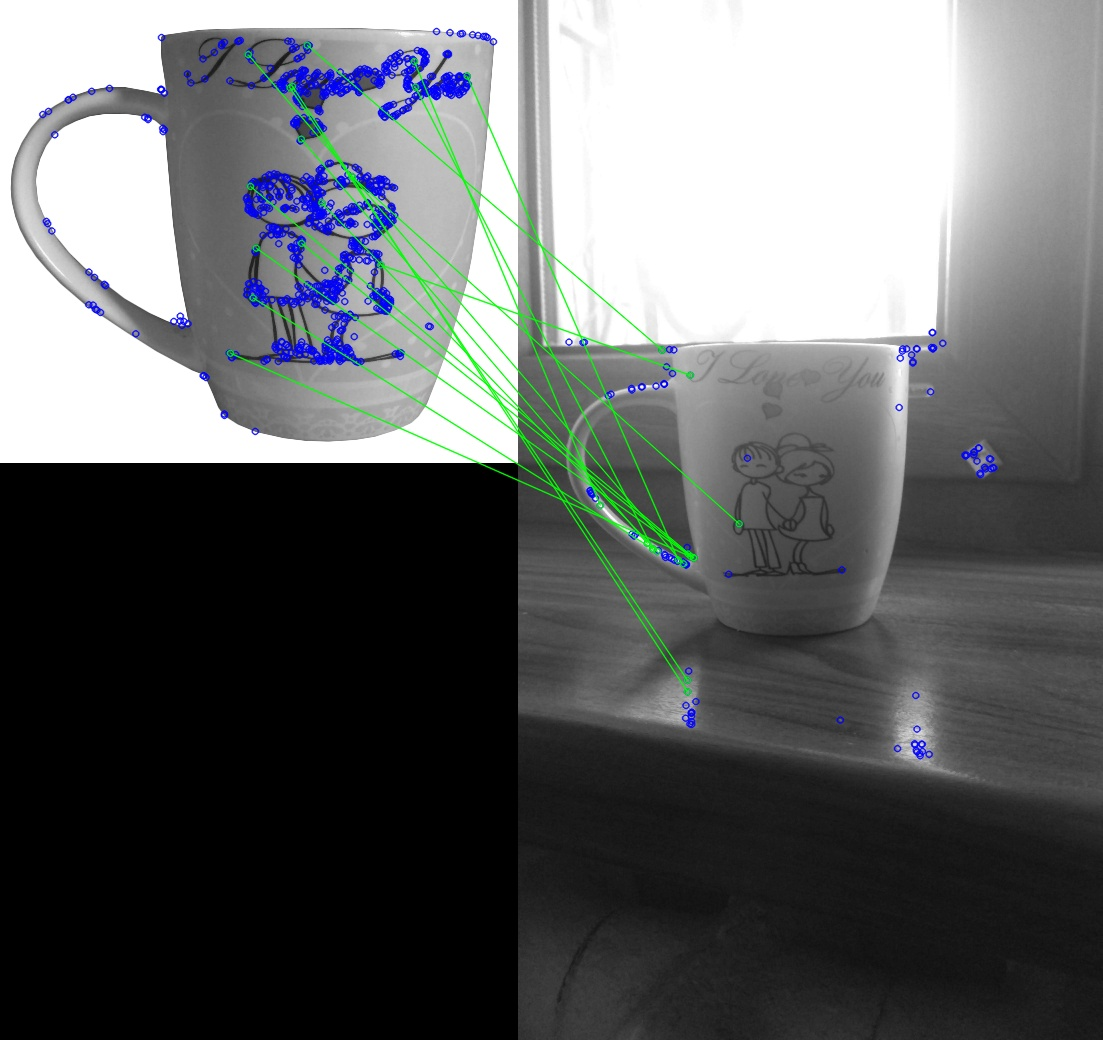

In [18]:
print(feature_matching_pair(train, test[114], True))
Image('peow.jpg', width = 400, height = 300)

In [30]:
data_sift = pd.read_csv('anticeptik_brisk.csv')

In [31]:
data = data_sift[data_sift['m1'] == -1]

In [32]:
data

,Unnamed: 0,id,m1,m2,size,x0.25,x0.2,x0.15
49,49,50,-1.0,-1.0,"(1032, 774)",0.163288,0.161121,0.144604
102,102,103,-1.0,-1.0,"(1032, 774)",0.159890,0.154804,0.145208


(0.6666666666666666, 96.83333333333333, 0.18070769309997559)


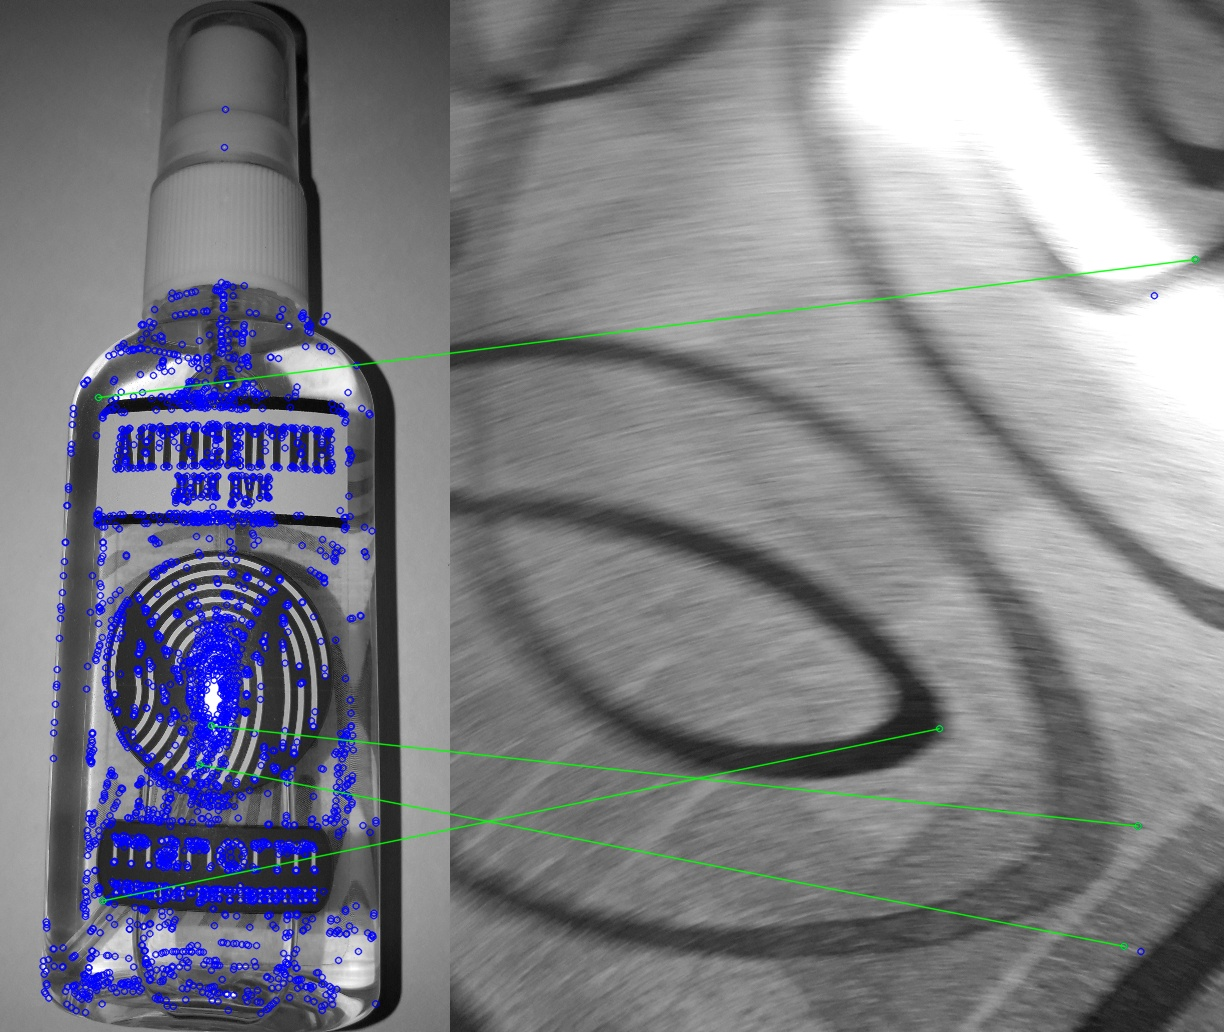

In [37]:
print(feature_matching_pair(train, test[102], True))
Image('peow.jpg', width = 400, height = 300)